# Задача:
Разработать модель предсказания в каждом регионе объема продаж в штуках любого, выбранного вами, вида банки напитка Coca Cola.
Модель должна предсказывать объем продаж на каждый час следующих суток (от последней даты транзакции в датасете).

# Описание полей:
| Поле       | Описание                          |
|------------|-----------------------------------|
| item_id    | Id транзакции                     |
| receipt_id | Id чека                           |
| device_id  | Id кассового аппарата             |
| local_date | Дата и время покупки              |
| barcode    | Штрихкод                          |
| price      | Цена покупки, рубли               |
| quantity   | Количество купленного товара, шт. |
| region     | Регион                            |



Импорт необходимых библиотек

In [1]:
import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

warnings.filterwarnings('ignore')


# Импорт данных и основные характеристики датасета

In [2]:
df = pd.read_csv('data/dataset.csv')
df.head()

,Unnamed: 0,item_id,receipt_id,device_id,local_date,barcode,price,quantity,region
0,0,11660931229,7364786357,352402250963288,2021-02-02 00:00:01,46200310,133.0,1.0,Нижегородская область
1,1,11660931230,7364786357,352402250963288,2021-02-02 00:00:01,4601501425437,100.0,1.0,Нижегородская область
2,2,11660931245,7364786362,352403362581574,2021-02-02 00:00:04,NaN,50.0,1.0,Москва
3,3,11660931313,7364786391,352399468048288,2021-02-02 01:00:11,NaN,29.0,1.0,Ульяновская область
4,4,11660931336,7364786406,352401023174844,2021-02-02 00:00:17,NaN,250.0,1.0,Москва


Выведем информацию о датасете

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2246094 entries, 0 to 2246093
Data columns (total 9 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   item_id     int64  
 2   receipt_id  int64  
 3   device_id   int64  
 4   local_date  object 
 5   barcode     object 
 6   price       float64
 7   quantity    float64
 8   region      object 
dtypes: float64(2), int64(4), object(3)
memory usage: 154.2+ MB


Выведем статистики датасета (численные признаки)

In [4]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2246094.0,1.123046e+06,6.483916e+05,0.000000e+00,5.615232e+05,1.123046e+06,1.684570e+06,2.246093e+06
item_id,2246094.0,1.169074e+10,2.530635e+07,1.164705e+10,1.166871e+10,1.168954e+10,1.171285e+10,1.173506e+10
receipt_id,2246094.0,7.381695e+09,1.433822e+07,7.356678e+09,7.369213e+09,7.381119e+09,7.394264e+09,7.406571e+09
device_id,2246094.0,3.524841e+14,4.029727e+12,3.523991e+14,3.524014e+14,3.524038e+14,3.524060e+14,8.651546e+14
price,2246094.0,4.189517e+02,1.203594e+04,-7.425000e+02,3.700000e+01,9.800000e+01,2.000000e+02,1.125000e+07
quantity,2246094.0,2.168133e+00,1.383289e+02,-9.350000e+03,1.000000e+00,1.000000e+00,1.000000e+00,9.500000e+04


Выведем статистики датасета (категориальные признаки)

In [5]:
df.describe(include=['object'])

,local_date,barcode,region
count,2246094,1034719,2245074
unique,418611,156857,85
top,2021-02-01 13:22:52,2000000000008,Московская область
freq,280,8347,134136


# Препроцессинг данных

Удаляем столбец "Unnamed: 0", который является дубликатом индекса

In [6]:
df.drop('Unnamed: 0', axis=1, inplace=True)

Проверим наличие пропущенных значений в датасете


In [7]:
missing_values = df.isna().sum().reset_index().rename(columns={'index': 'Column', 0: 'Number of missing values'})
missing_values['Percentage'] = missing_values['Number of missing values'] / df.shape[0]
missing_values[missing_values['Number of missing values'] > 0]

,Column,Number of missing values,Percentage
4,barcode,1211375,0.539325
7,region,1020,0.000454


Так как нам необходимо предсказать объем продаж определенного товара, а уникальность товара как раз определяется по штрих-коду, то мы можем удалить строки с пропущенными значениями в столбце 'barcode'

In [8]:
df.dropna(subset=['barcode'], inplace=True)

Посмотрим на количество и процент пропущенных значений в столбце 'region'

In [9]:
missing_values_deleted_missing_barcode = df.isna().sum().reset_index().rename(
    columns={'index': 'Column', 0: 'Number of missing values'})
missing_values_deleted_missing_barcode['Percentage'] = missing_values_deleted_missing_barcode[
                                                           'Number of missing values'] / df.shape[0]
missing_values_deleted_missing_barcode[missing_values_deleted_missing_barcode['Number of missing values'] > 0]

,Column,Number of missing values,Percentage
7,region,800,0.000773


Так как пропусков в столбце 'region' на несколько порядков меньше 1%, то мы можем практически безболезненно удалить строки с пропущенными значениями в столбце 'region'

In [10]:
df.dropna(subset=['region'], inplace=True)

Проверим, что пропущенных значений больше нет

In [11]:
df.isna().sum().sum()

0

Проверим наличие дубликатов в датасете

In [12]:
df.duplicated().sum()

0

Мы видим, что в датасете нет дубликатов, но, возможно, есть дубликаты по id. Проверим это

Проверим уникальность id транзакций

In [13]:
df['item_id'].nunique() == df.shape[0]

True

Можно понять, что каждая транзакция была уникальна. Больше для нас это поле не несет полезной информации

Проверим уникальность id чеков

In [14]:
df['receipt_id'].nunique() == df.shape[0]

False

Так как id чеков не уникальны, то посмотрим на дубликаты

In [15]:
df[df['receipt_id'].duplicated(keep=False)].sort_values(by='receipt_id')

,item_id,receipt_id,device_id,local_date,barcode,price,quantity,region
364,11647054423,7356679260,352403013410351,2021-02-01 00:02:32,2000000000428,125.00,1.0,Санкт-Петербург
365,11647054424,7356679260,352403013410351,2021-02-01 00:02:32,40822938,65.00,1.0,Санкт-Петербург
367,11647054529,7356679326,352405853057387,2021-02-01 00:02:47,4606203098941,139.00,1.0,Рязанская область
368,11647054530,7356679326,352405853057387,2021-02-01 00:02:47,4606203098941,139.00,1.0,Рязанская область
398,11647056392,7356680548,352403718712896,2021-02-01 00:06:46,2000000000428,1.00,8.0,Курская область
...,...,...,...,...,...,...,...,...
1646184,11735053948,7406570819,352402666144546,2021-02-06 23:58:23,46209474,158.00,1.0,Орловская область
1646185,11735053949,7406570819,352402666144546,2021-02-06 23:58:23,4607001776437,25.00,1.0,Орловская область
1646191,11735054690,7406571235,352402250963288,2021-02-06 23:59:15,4601501006155,165.00,2.0,Нижегородская область
1646193,11735054692,7406571235,352402250963288,2021-02-06 23:59:15,4606838003525,25.00,1.0,Нижегородская область


Видим, что у нас есть дубликаты по id чеков, но с разными значениями в столбце 'barcode'.

Нам необходимо прогнозировать объем продаж банок напитка Coca Cola, поэтому спарсим штрих-коды банок Coca Cola и оставим только те строки, где штрих-коды соответствуют банкам Coca Cola.

In [16]:
import requests
from bs4 import BeautifulSoup

LOAD_FROM_FILE_COCA_COLA_BARCODES = True
if LOAD_FROM_FILE_COCA_COLA_BARCODES:
    df_barcode_name_coca_cola = pd.read_csv('data/df_barcode_name_coca_cola.csv')
    df_barcode_name_coca_cola['barcode'] = df_barcode_name_coca_cola['barcode'].astype(df['barcode'].dtype)
else:
    df_barcode_name_coca_cola = pd.DataFrame(columns=['barcode', 'name'])

    url = "https://barcode-list.ru/barcode/RU/Поиск.htm?barcode=Coca+cola"

    response = requests.get(url)

    if response.status_code == 200:
        soup = BeautifulSoup(response.text, 'html.parser')

        items = soup.find_all('tr')

        for item in items:
            cols = item.find_all('td')
            if len(cols) >= 2:
                barcode = cols[1].text.strip()
                name = cols[2].text.strip()
                df_barcode_name_coca_cola = pd.concat(
                    [df_barcode_name_coca_cola, pd.DataFrame({'barcode': [barcode], 'name': [name]})],
                    ignore_index=True)

    df_barcode_name_coca_cola.drop(0, inplace=True)  # Выкинем первую строку, т.к. там мусор
    df_barcode_name_coca_cola.drop_duplicates(subset='barcode', inplace=True)  # Удалим дубликаты штрих-кодов
    df_barcode_name_coca_cola.to_csv('data/df_barcode_name_coca_cola.csv', index=False)

df_barcode_name_coca_cola

,barcode,name
0,26102116845,"""Coca-Cola""Стакан 36 cl (2 шт.)"
1,49000004632,"НАПИТОК Б/АЛК. ""COCA COLA MEXICO"" С/Г 0,355 Л ..."
2,49000049930,"НАПИТОК Б/АЛК. ""COCA COLA"" 0,25 Л АЛЮМ.БУТЫЛКА..."
3,49000065206,"НАПИТОК Б/АЛ ""COCA-COLA LIFE"" 0.355 Ж/Б США"
4,50051811582,Lip Smacker Coca Cola Set
...,...,...
301,90494406,"Мин. вод. ""Coca-cola"" Бонаква газ. 0.5л"
302,90494741,COCA COLA 05 L
303,90495489,Coca Cola. Cappy Shaftali 200 ml
304,90495793,Газ.напиток Coca-cola / Fanta 250ml


Теперь мы можем оставить только те строки, где штрихкоды соответствуют банкам Coca Cola

In [17]:
LOAD_FROM_FILE_DF_MERGED = True
if LOAD_FROM_FILE_DF_MERGED:
    df_merged = pd.read_csv('data/df_merged.csv')
    df_merged['barcode'] = df_merged['barcode'].astype(df['barcode'].dtype)
else:
    df_merged = df.merge(df_barcode_name_coca_cola, on='barcode', how='inner')
    df_merged.to_csv('data/df_merged.csv', index=False)
df_merged

,item_id,receipt_id,device_id,local_date,barcode,price,quantity,region,name
0,11660935105,7364788741,352402818554872,2021-02-02 00:07:33,5449000054227,68.0,1.0,Москва,НАПИТОК COCA-COLA С/Г 1л
1,11647057035,7356680972,352402818554872,2021-02-01 00:08:09,5449000054227,68.0,1.0,Москва,НАПИТОК COCA-COLA С/Г 1л
2,11660956406,7364801593,352402818554872,2021-02-02 00:56:07,5449000054227,68.0,1.0,Москва,НАПИТОК COCA-COLA С/Г 1л
3,11704496660,7389608055,352402818554872,2021-02-05 00:06:59,5449000054227,68.0,1.0,Москва,НАПИТОК COCA-COLA С/Г 1л
4,11704500400,7389610215,352401038709290,2021-02-05 07:13:22,5449000054227,84.0,1.0,Приморский край,НАПИТОК COCA-COLA С/Г 1л
...,...,...,...,...,...,...,...,...,...
4142,11708469168,7391863708,356646119490350,2021-02-05 10:35:02,54492509,65.0,1.0,Московская область,Напиток COCA-COLA стекло 250мл
4143,11702167129,7388277954,352401779039216,2021-02-04 17:40:10,54492509,48.0,1.0,Московская область,Напиток COCA-COLA стекло 250мл
4144,11660335997,7364431385,356646119490350,2021-02-01 19:56:21,54492509,65.0,1.0,Московская область,Напиток COCA-COLA стекло 250мл
4145,11660594448,7364583592,352399667615722,2021-02-01 20:45:13,54492509,40.0,1.0,Московская область,Напиток COCA-COLA стекло 250мл


Наш датасет уменьшился с более чем 2 миллионов записей до 4147 записей

Выведем штрих-коды по популярности

In [18]:
df_merged['barcode'].value_counts()

barcode
5449000228970    727
5449000000286    712
5449000000996    525
54491472         486
5449000000439    147
40822426         141
5449000011527    132
40822938         124
5449000054227    101
5449000253101     89
5449000004840     83
90494406          66
5449000005489     65
5449000014535     60
5449000004864     56
54491069          55
5449000231659     50
5449000027450     48
5449000026583     48
42099697          35
5449000032805     28
5449000098153     26
5449000131805     25
5449000022189     24
5449000131836     22
50112128          19
5449000006271     19
5053990101597     19
5449000052926     18
5449000012203     16
5449000098917     16
5053990101573     15
5053990106868     15
8000500191712     14
80941828          11
5449000000729     10
5449000124487     10
5449000133335      9
5449000045478      9
5449000098542      8
5449000265098      7
5053990106981      7
5449000022172      7
5449000008046      6
5449000050939      6
5449000021724      5
5449000093943      5
54492

Далее будем рассматривать данные с самым популярным штрих-кодом

# Анализ данных

In [19]:
df_most_popular_coca_cola = df_merged[df_merged['barcode'] == df_merged['barcode'].value_counts().idxmax()].drop(
    'barcode', axis=1)
df_most_popular_coca_cola

,item_id,receipt_id,device_id,local_date,price,quantity,region,name
1513,11660947029,7364795779,352399549066359,2021-02-02 02:32:33,65.0,1.0,Ханты-Мансийский автономный округ,Coca-cola 0.9л
1514,11647053013,7356678366,352402118476056,2021-01-31 23:59:59,95.0,1.0,Брянская область,Coca-cola 0.9л
1515,11647062225,7356684466,352400986399247,2021-02-01 01:19:32,69.0,1.0,Самарская область,Coca-cola 0.9л
1516,11729206618,7403320830,352406986160579,2021-02-06 19:07:57,80.0,1.0,Иркутская область,Coca-cola 0.9л
1517,11647074677,7356692611,352406370923721,2021-02-01 00:49:21,70.0,1.0,Санкт-Петербург,Coca-cola 0.9л
...,...,...,...,...,...,...,...,...
2235,11675220847,7372987238,352405600084407,2021-02-03 01:46:36,75.0,1.0,Омская область,Coca-cola 0.9л
2236,11675236890,7372996511,352400986399247,2021-02-03 00:01:59,69.0,1.0,Самарская область,Coca-cola 0.9л
2237,11660846078,7364731936,352406485283006,2021-02-01 22:24:41,64.0,1.0,Республика Адыгея,Coca-cola 0.9л
2238,11660855319,7364737207,352405104392991,2021-02-01 22:32:29,93.0,1.0,Краснодарский край,Coca-cola 0.9л


Наш датасет еще уменьшился до 727 записей.

Уберем из рассмотрения id транзакций, id чеков, id кассового аппарата, цену и название товара, так больше не несут полезной информации

In [20]:
df_most_popular_coca_cola.drop(['item_id', 'receipt_id', 'device_id', 'price', 'name'], axis=1, inplace=True)

Выделим год, месяц, день, час и день недели в отдельные столбцы, а также добавим поле is_weekend, которое будет показывать, является ли день выходным

In [21]:
df_most_popular_coca_cola['local_date'] = pd.to_datetime(df_most_popular_coca_cola['local_date'])
df_most_popular_coca_cola['year'] = df_most_popular_coca_cola['local_date'].dt.year
df_most_popular_coca_cola['month'] = df_most_popular_coca_cola['local_date'].dt.month
df_most_popular_coca_cola['day'] = df_most_popular_coca_cola['local_date'].dt.day
df_most_popular_coca_cola['hour'] = df_most_popular_coca_cola['local_date'].dt.hour
df_most_popular_coca_cola['weekday'] = df_most_popular_coca_cola['local_date'].dt.weekday
df_most_popular_coca_cola['is_weekend'] = df_most_popular_coca_cola['weekday'].apply(
    lambda x: 1 if x >= 5 else 0).astype(np.int32)
df_most_popular_coca_cola.drop('local_date', axis=1, inplace=True)

Сгруппируем данные по региону, месяцу, дню, часу и посчитаем сумму проданных единиц товара

In [22]:
df_most_popular_coca_cola = \
    df_most_popular_coca_cola.groupby(['region', 'year', 'month', 'day', 'hour', 'weekday', 'is_weekend'])[
        'quantity'].sum().reset_index().sort_values(by='quantity', ascending=False)
df_most_popular_coca_cola['date'] = pd.to_datetime(df_most_popular_coca_cola[['year', 'month', 'day', 'hour']])
df_most_popular_coca_cola

,region,year,month,day,hour,weekday,is_weekend,quantity,date
493,Санкт-Петербург,2021,2,1,19,0,0,31.0,2021-02-01 19:00:00
520,Санкт-Петербург,2021,2,6,13,5,1,10.0,2021-02-06 13:00:00
491,Санкт-Петербург,2021,2,1,17,0,0,10.0,2021-02-01 17:00:00
490,Санкт-Петербург,2021,2,1,16,0,0,7.0,2021-02-01 16:00:00
218,Московская область,2021,2,2,14,1,0,6.0,2021-02-02 14:00:00
...,...,...,...,...,...,...,...,...,...
211,Московская область,2021,2,1,15,0,0,1.0,2021-02-01 15:00:00
209,Московская область,2021,2,1,13,0,0,1.0,2021-02-01 13:00:00
208,Московская область,2021,2,1,11,0,0,1.0,2021-02-01 11:00:00
207,Московская область,2021,2,1,10,0,0,1.0,2021-02-01 10:00:00


Можем увидеть, что больше всего продаж было в Санкт-Петербурге первого февраля в 19 часов


Проверим количество уникальных значений в столбце 'year'

In [23]:
df_most_popular_coca_cola['year'].value_counts()

year
2021    612
Name: count, dtype: int64

Мы видим, что у нас есть данные только за 2021 год

Посмотрим на количество уникальных значений в столбце 'month'

In [24]:
df_most_popular_coca_cola['month'].value_counts()

month
2    604
1      8
Name: count, dtype: int64

Мы видим, что у нас есть измерения только за январь и февраль

Посмотрим, в какие дни в январе и феврале были продажи

In [25]:
df_most_popular_coca_cola[df_most_popular_coca_cola['month'] == 1]['day'].value_counts(), \
    df_most_popular_coca_cola[df_most_popular_coca_cola['month'] == 2]['day'].value_counts()

(day
 31    5
 23    1
 29    1
 10    1
 Name: count, dtype: int64,
 day
 6    127
 3    103
 5     97
 1     94
 2     91
 4     91
 7      1
 Name: count, dtype: int64)

Удалим из рассмотрения дни, где было только одно измерение

In [26]:
df_most_popular_coca_cola = df_most_popular_coca_cola[
    df_most_popular_coca_cola['day'].isin(
        df_most_popular_coca_cola['day'].value_counts()[df_most_popular_coca_cola['day'].value_counts() > 1].index)]

Посмотрим распределение продаж по часам

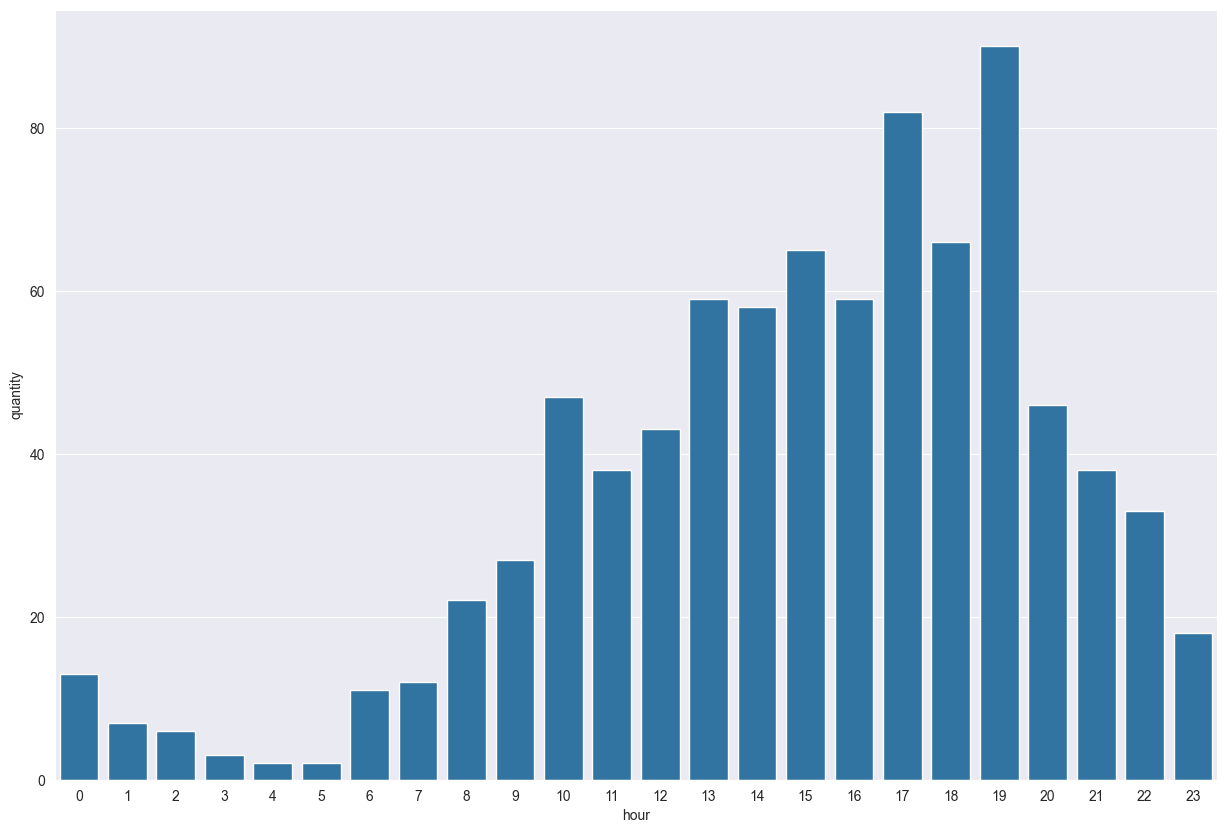

In [27]:
plt.figure(figsize=(15, 10))
sns.barplot(data=df_most_popular_coca_cola.groupby('hour')['quantity'].sum().reset_index(), x='hour', y='quantity')
plt.show()

Видим, что распределение не является нормальным

Посмотрим, в какие дни недели чаще продавались товары

In [28]:
df_most_popular_coca_cola['weekday'].value_counts(normalize=True).mul(100).round(2).rename('percentage')

weekday
5    20.89
2    16.94
4    15.95
0    15.46
1    14.97
3    14.97
6     0.82
Name: percentage, dtype: float64

Видим, что чаще всего продавались товары в субботу и будние дни

Посмотрим, в какое время дня чаще всего продавались товары

In [29]:
df_most_popular_coca_cola['hour'].value_counts(normalize=True).mul(100).round(2).rename('percentage')

hour
17    9.05
18    8.22
15    7.89
16    7.40
19    6.91
13    6.41
20    6.25
14    6.25
12    5.92
10    5.26
21    4.77
11    4.44
9     3.95
22    3.29
8     2.96
0     2.14
23    1.97
7     1.97
6     1.64
1     1.15
2     0.99
3     0.49
4     0.33
5     0.33
Name: percentage, dtype: float64

Видим, что больше всего продаж приходится на вечернее время

Посмотрим на boxplot количества продаж единиц товара по дням недели

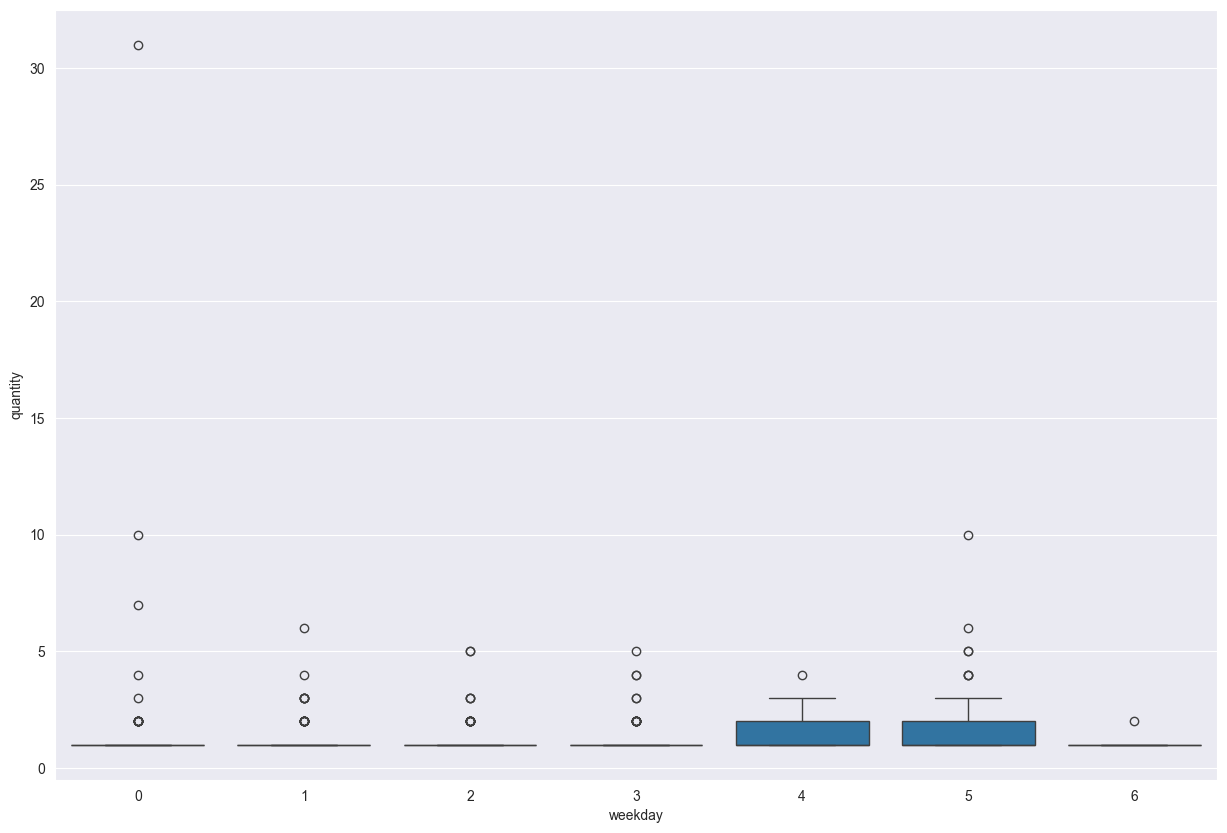

In [30]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_most_popular_coca_cola, x='weekday', y='quantity')
plt.show()

По данному графику видно, что чаще всего покупают не более одной банки Coca Cola в день, за исключением пятницы и субботы. Значения, которые выходят за границы "усов", в данном случае можно не считать за выбросы.

Посмотрим на boxplot количества продаж единиц товара по часам

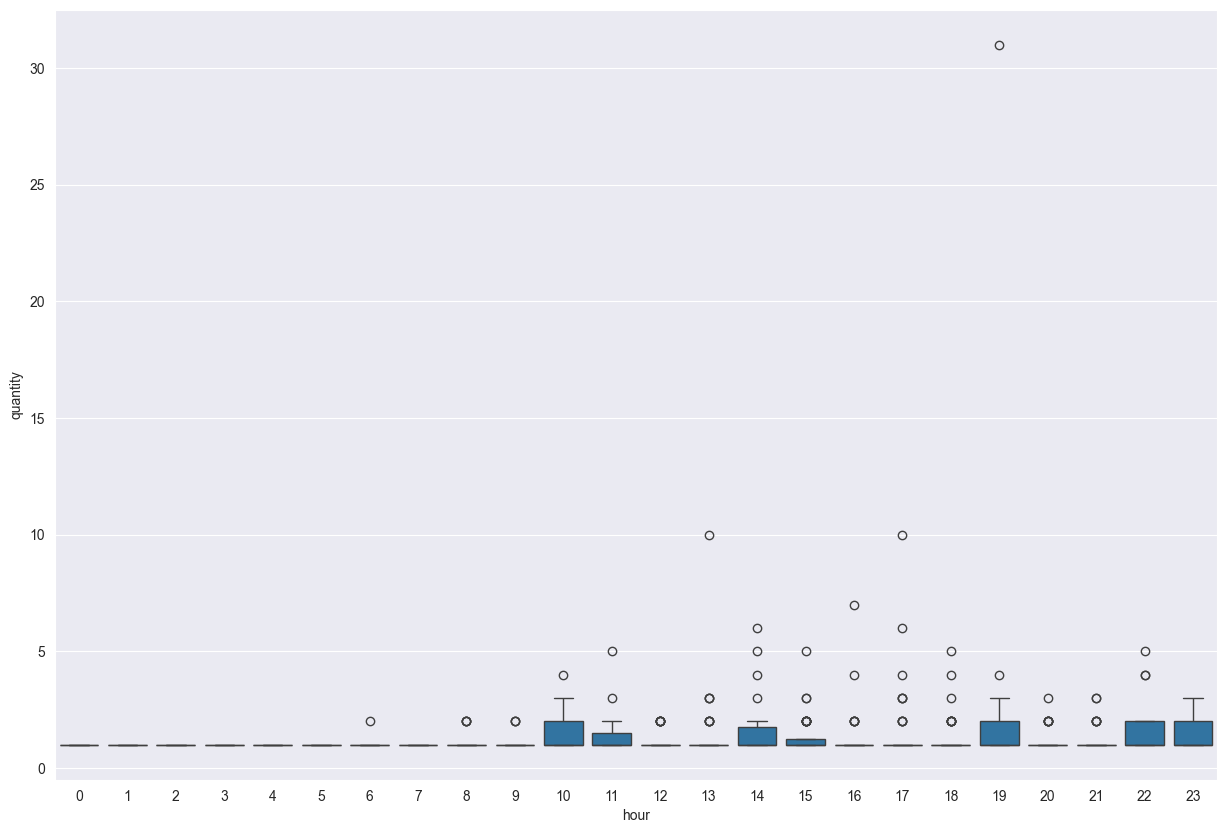

In [31]:
plt.figure(figsize=(15, 10))
sns.boxplot(data=df_most_popular_coca_cola, x='hour', y='quantity')
plt.show()

По данному графику видно, что чаще всего покупают не более одной банки Coca Cola в конкретный час. Значения, которые выходят за границы "усов", в данном случае можно не считать за выбросы.

# Недостающие даты и часы в датасете

У нас есть данные за январь и февраль 2021 года, но не для всех дней и часов: либо товар не покупали, либо измерения не проводились.

Заполним пропущенные значения, чтобы наша модель могла обучиться на полных данных

Заполнение для первого месяца

In [32]:
import itertools

df_most_popular_coca_cola_first_month = df_most_popular_coca_cola[df_most_popular_coca_cola['month'] == 1]
regions = df_most_popular_coca_cola['region'].unique()
days = range(df_most_popular_coca_cola_first_month['day'].min(), df_most_popular_coca_cola_first_month['day'].max() + 1)
hours = range(0, 24)

all_combinations_first_month = pd.DataFrame(
    list(itertools.product(regions, [2021], [1], days, hours, )),
    columns=['region', 'year', 'month', 'day', 'hour', ]
)

all_combinations_first_month

,region,year,month,day,hour
0,Санкт-Петербург,2021,1,31,0
1,Санкт-Петербург,2021,1,31,1
2,Санкт-Петербург,2021,1,31,2
3,Санкт-Петербург,2021,1,31,3
4,Санкт-Петербург,2021,1,31,4
...,...,...,...,...,...
1315,Курганская область,2021,1,31,19
1316,Курганская область,2021,1,31,20
1317,Курганская область,2021,1,31,21
1318,Курганская область,2021,1,31,22


Заполнение для второго месяца

In [33]:
import itertools

df_most_popular_coca_cola_second_month = df_most_popular_coca_cola[df_most_popular_coca_cola['month'] == 2]
regions = df_most_popular_coca_cola['region'].unique()
days = range(df_most_popular_coca_cola_second_month['day'].min(),
             df_most_popular_coca_cola_second_month['day'].max() + 1)
hours = range(0, 24)

all_combinations_second_month = pd.DataFrame(
    list(itertools.product(regions, [2021], [2], days, hours, )),
    columns=['region', 'year', 'month', 'day', 'hour', ]
)

all_combinations_second_month

,region,year,month,day,hour
0,Санкт-Петербург,2021,2,1,0
1,Санкт-Петербург,2021,2,1,1
2,Санкт-Петербург,2021,2,1,2
3,Санкт-Петербург,2021,2,1,3
4,Санкт-Петербург,2021,2,1,4
...,...,...,...,...,...
7915,Курганская область,2021,2,6,19
7916,Курганская область,2021,2,6,20
7917,Курганская область,2021,2,6,21
7918,Курганская область,2021,2,6,22


In [34]:
all_combinations = pd.concat([all_combinations_first_month, all_combinations_second_month], ignore_index=True)
all_combinations

,region,year,month,day,hour
0,Санкт-Петербург,2021,1,31,0
1,Санкт-Петербург,2021,1,31,1
2,Санкт-Петербург,2021,1,31,2
3,Санкт-Петербург,2021,1,31,3
4,Санкт-Петербург,2021,1,31,4
...,...,...,...,...,...
9235,Курганская область,2021,2,6,19
9236,Курганская область,2021,2,6,20
9237,Курганская область,2021,2,6,21
9238,Курганская область,2021,2,6,22


In [35]:
all_combinations['date'] = pd.to_datetime(all_combinations[['year', 'month', 'day', 'hour']])
all_combinations

,region,year,month,day,hour,date
0,Санкт-Петербург,2021,1,31,0,2021-01-31 00:00:00
1,Санкт-Петербург,2021,1,31,1,2021-01-31 01:00:00
2,Санкт-Петербург,2021,1,31,2,2021-01-31 02:00:00
3,Санкт-Петербург,2021,1,31,3,2021-01-31 03:00:00
4,Санкт-Петербург,2021,1,31,4,2021-01-31 04:00:00
...,...,...,...,...,...,...
9235,Курганская область,2021,2,6,19,2021-02-06 19:00:00
9236,Курганская область,2021,2,6,20,2021-02-06 20:00:00
9237,Курганская область,2021,2,6,21,2021-02-06 21:00:00
9238,Курганская область,2021,2,6,22,2021-02-06 22:00:00


In [36]:
all_combinations['weekday'] = all_combinations['date'].dt.weekday
all_combinations['is_weekend'] = all_combinations['weekday'].apply(lambda x: 1 if x >= 5 else 0).astype(np.int32)
all_combinations

,region,year,month,day,hour,date,weekday,is_weekend
0,Санкт-Петербург,2021,1,31,0,2021-01-31 00:00:00,6,1
1,Санкт-Петербург,2021,1,31,1,2021-01-31 01:00:00,6,1
2,Санкт-Петербург,2021,1,31,2,2021-01-31 02:00:00,6,1
3,Санкт-Петербург,2021,1,31,3,2021-01-31 03:00:00,6,1
4,Санкт-Петербург,2021,1,31,4,2021-01-31 04:00:00,6,1
...,...,...,...,...,...,...,...,...
9235,Курганская область,2021,2,6,19,2021-02-06 19:00:00,5,1
9236,Курганская область,2021,2,6,20,2021-02-06 20:00:00,5,1
9237,Курганская область,2021,2,6,21,2021-02-06 21:00:00,5,1
9238,Курганская область,2021,2,6,22,2021-02-06 22:00:00,5,1


In [37]:
LOAD_FROM_FILE_DF_MOST_POPULAR_COCA_COLA_ALL = False
if LOAD_FROM_FILE_DF_MOST_POPULAR_COCA_COLA_ALL:
    df_most_popular_coca_cola_all = pd.read_csv('data/df_most_popular_coca_cola_all_s.csv')
    df_most_popular_coca_cola_all['date'] = pd.to_datetime(df_most_popular_coca_cola_all['date'])
else:
    df_most_popular_coca_cola['date'] = pd.to_datetime(df_most_popular_coca_cola[['year', 'month', 'day', 'hour']])
    df_most_popular_coca_cola_all = pd.merge(all_combinations, df_most_popular_coca_cola,
                                             on=['region', 'date', 'year', 'month', 'day', 'hour', 'weekday',
                                                 'is_weekend'], how='left')
    df_most_popular_coca_cola_all.to_csv('data/df_most_popular_coca_cola_all_s.csv', index=False)

df_most_popular_coca_cola_all

,region,year,month,day,hour,date,weekday,is_weekend,quantity
0,Санкт-Петербург,2021,1,31,0,2021-01-31 00:00:00,6,1,NaN
1,Санкт-Петербург,2021,1,31,1,2021-01-31 01:00:00,6,1,NaN
2,Санкт-Петербург,2021,1,31,2,2021-01-31 02:00:00,6,1,NaN
3,Санкт-Петербург,2021,1,31,3,2021-01-31 03:00:00,6,1,NaN
4,Санкт-Петербург,2021,1,31,4,2021-01-31 04:00:00,6,1,NaN
...,...,...,...,...,...,...,...,...,...
9235,Курганская область,2021,2,6,19,2021-02-06 19:00:00,5,1,NaN
9236,Курганская область,2021,2,6,20,2021-02-06 20:00:00,5,1,NaN
9237,Курганская область,2021,2,6,21,2021-02-06 21:00:00,5,1,NaN
9238,Курганская область,2021,2,6,22,2021-02-06 22:00:00,5,1,NaN


Будем считать, что в те дни и часы, где данных нет, продажи были равны 0

In [38]:
df_most_popular_coca_cola_all['quantity'].fillna(0, inplace=True)
df_most_popular_coca_cola_all['quantity'] = df_most_popular_coca_cola_all['quantity'].astype(np.int32)
df_most_popular_coca_cola_all

,region,year,month,day,hour,date,weekday,is_weekend,quantity
0,Санкт-Петербург,2021,1,31,0,2021-01-31 00:00:00,6,1,0
1,Санкт-Петербург,2021,1,31,1,2021-01-31 01:00:00,6,1,0
2,Санкт-Петербург,2021,1,31,2,2021-01-31 02:00:00,6,1,0
3,Санкт-Петербург,2021,1,31,3,2021-01-31 03:00:00,6,1,0
4,Санкт-Петербург,2021,1,31,4,2021-01-31 04:00:00,6,1,0
...,...,...,...,...,...,...,...,...,...
9235,Курганская область,2021,2,6,19,2021-02-06 19:00:00,5,1,0
9236,Курганская область,2021,2,6,20,2021-02-06 20:00:00,5,1,0
9237,Курганская область,2021,2,6,21,2021-02-06 21:00:00,5,1,0
9238,Курганская область,2021,2,6,22,2021-02-06 22:00:00,5,1,0


# Данные для моделирования

Сгенерируем несколько признаков:
- Лаги за 24 часа
- Скользящее среднее за 24 часа
- Максимальное, среднее и минимальное количество проданных единиц товара по региону
- Максимальное, среднее и минимальное количество проданных единиц товара по часу
- Суммарное количество проданных единиц товара по часу
- Суммарное количество проданных единиц товара по региону

In [39]:
def create_lags(df, lag_cols, lags):
    for col in lag_cols:
        for lag in range(1, lags + 1):
            df[f'{col}_lag_{lag}'] = df.groupby('region')[col].shift(lag)
    return df


df_for_regressor = df_most_popular_coca_cola_all.sort_values(by=['region', 'date'])
df_for_regressor = create_lags(df_for_regressor, ['quantity'], 24)
df_for_regressor['rolling_mean_24'] = df_for_regressor.groupby('region')['quantity'].transform(
    lambda x: x.rolling(window=24).mean())

df_for_regressor['max_quantity_region'] = df_for_regressor.groupby('region')['quantity'].transform('max')
df_for_regressor['mean_quantity_region'] = df_for_regressor.groupby('region')['quantity'].transform('mean')
df_for_regressor['min_quantity_region'] = df_for_regressor.groupby('region')['quantity'].transform('min')
df_for_regressor['max_quantity_hour'] = df_for_regressor.groupby('hour')['quantity'].transform('max')
df_for_regressor['mean_quantity_hour'] = df_for_regressor.groupby('hour')['quantity'].transform('mean')
df_for_regressor['min_quantity_hour'] = df_for_regressor.groupby('hour')['quantity'].transform('min')

df_for_regressor['sum_quantity_hour'] = df_for_regressor.groupby('hour')['quantity'].transform('sum')
df_for_regressor['sum_quantity_region'] = df_for_regressor.groupby('region')['quantity'].transform('sum')

df_for_regressor.dropna(inplace=True)

# df_for_regressor_date_set_index - обобщенные по дате данные по всем регионам
df_for_regressor_date_set_index = df_for_regressor.groupby('date')['quantity'].sum()

У нас не так много данных, полученных действительно благодаря измерениям, поэтому не будем разбивать на обучающую и тестовую выборки и для обучения модели будем использовать весь датасет

In [40]:
features = (['year', 'month', 'day', 'hour', 'weekday', 'is_weekend',
             'rolling_mean_24',
             'max_quantity_region',
             'mean_quantity_region',
             'min_quantity_region',
             'max_quantity_hour',
             'mean_quantity_hour',
             'min_quantity_hour',
             'sum_quantity_hour',
             'sum_quantity_region'] +
            [f'quantity_lag_{i}' for i in
             range(1, 25)])

X = df_for_regressor[features]
y = df_for_regressor['quantity']

Посмотрим на корреляцию между признаками

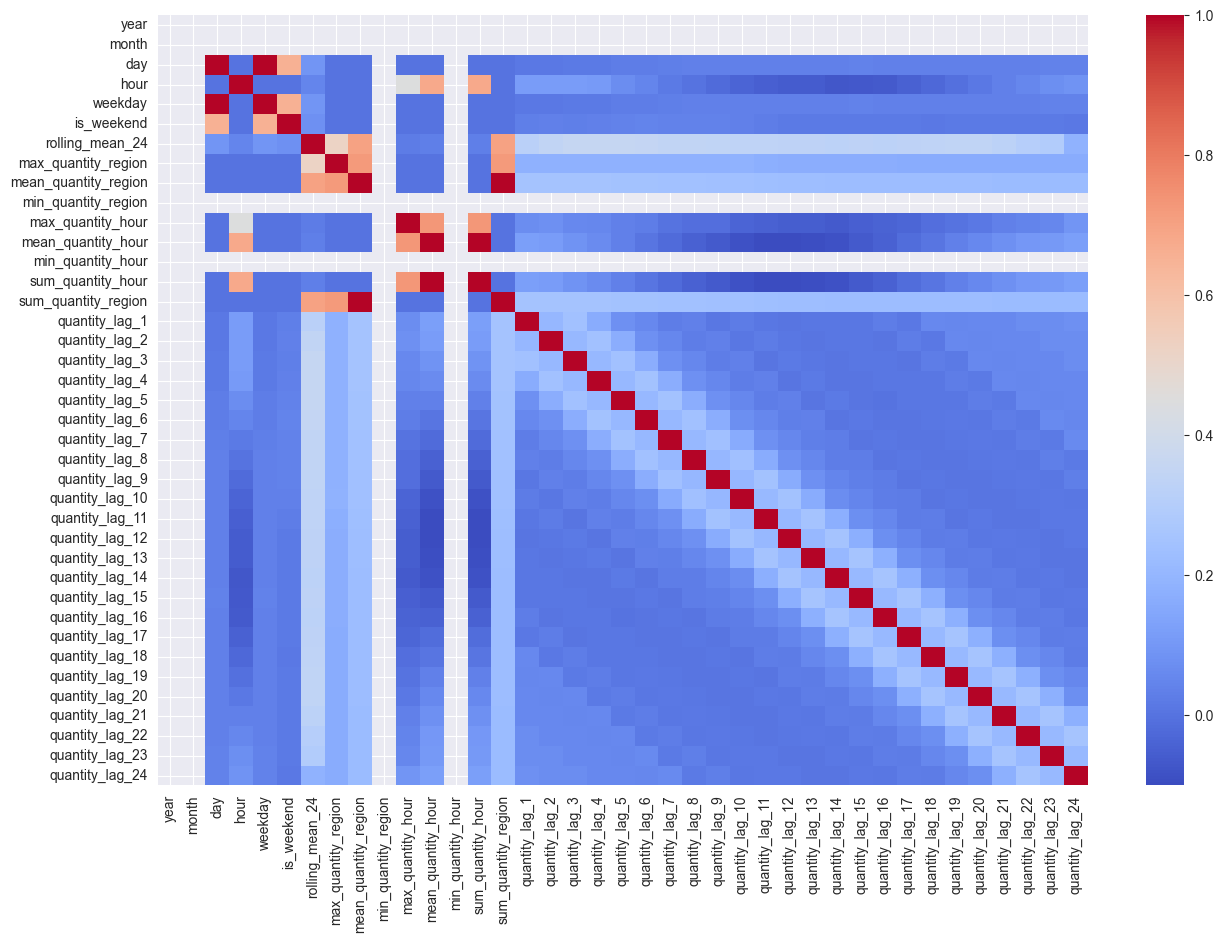

In [41]:
plt.figure(figsize=(15, 10))
sns.heatmap(X.corr(), annot=False, fmt='.2f', cmap='coolwarm')
plt.show()

Мы видим, что между сильной корреляции между признаками нет. Более сильная наблюдается между скользящим средним и лагами

# STL декомпозиция

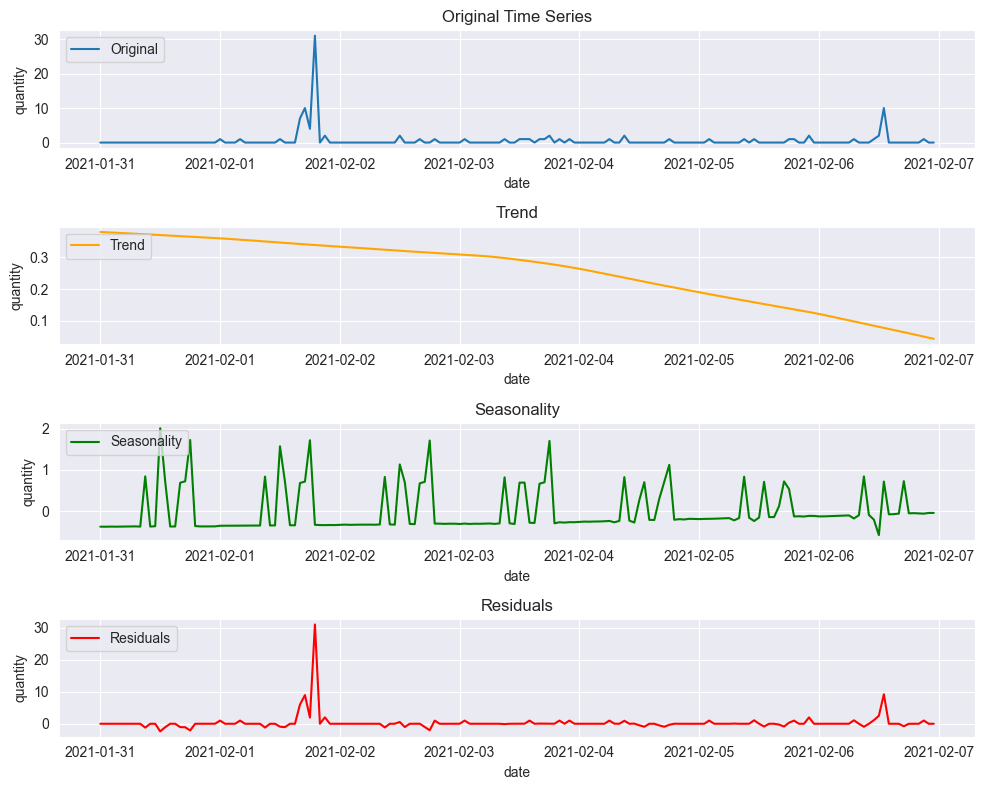

In [42]:
from statsmodels.tsa.seasonal import STL

def plot_decomposition(df, region=None):
    if region is None:
        df_decomposed = df.groupby('date')['quantity'].sum().reset_index()
    else:
        df_decomposed = df[df['region'] == region].groupby('date')['quantity'].sum().reset_index()
    stl = STL(df_decomposed['quantity'], period=24, robust=True)
    result = stl.fit()

    trend = result.trend
    seasonal = result.seasonal
    resid = result.resid

    plt.figure(figsize=(10, 8))

    plt.subplot(4, 1, 1)
    sns.lineplot(data=df_decomposed, x='date', y='quantity', label='Original')
    plt.legend(loc='upper left')
    plt.title('Original Time Series')

    plt.subplot(4, 1, 2)
    sns.lineplot(data=pd.DataFrame({'date': df_decomposed['date'], 'quantity': trend}), x='date',
                 y='quantity', label='Trend', color='orange')
    plt.legend(loc='upper left')
    plt.title('Trend')

    plt.subplot(4, 1, 3)
    sns.lineplot(data=pd.DataFrame({'date': df_decomposed['date'], 'quantity': seasonal}), x='date',
                 y='quantity', label='Seasonality', color='green')
    plt.legend(loc='upper left')
    plt.title('Seasonality')

    plt.subplot(4, 1, 4)
    sns.lineplot(data=pd.DataFrame({'date': df_decomposed['date'], 'quantity': resid}), x='date',
                 y='quantity', label='Residuals', color='red')
    plt.legend(loc='upper left')
    plt.title('Residuals')

    plt.tight_layout()
    plt.show()


plot_decomposition(df_most_popular_coca_cola_all, region='Санкт-Петербург')

Это график STL декомпозиции для Санкт-Петербурга.

Посмотрим на STL декомпозицию для обобщенного по дате по всех регионов ряда

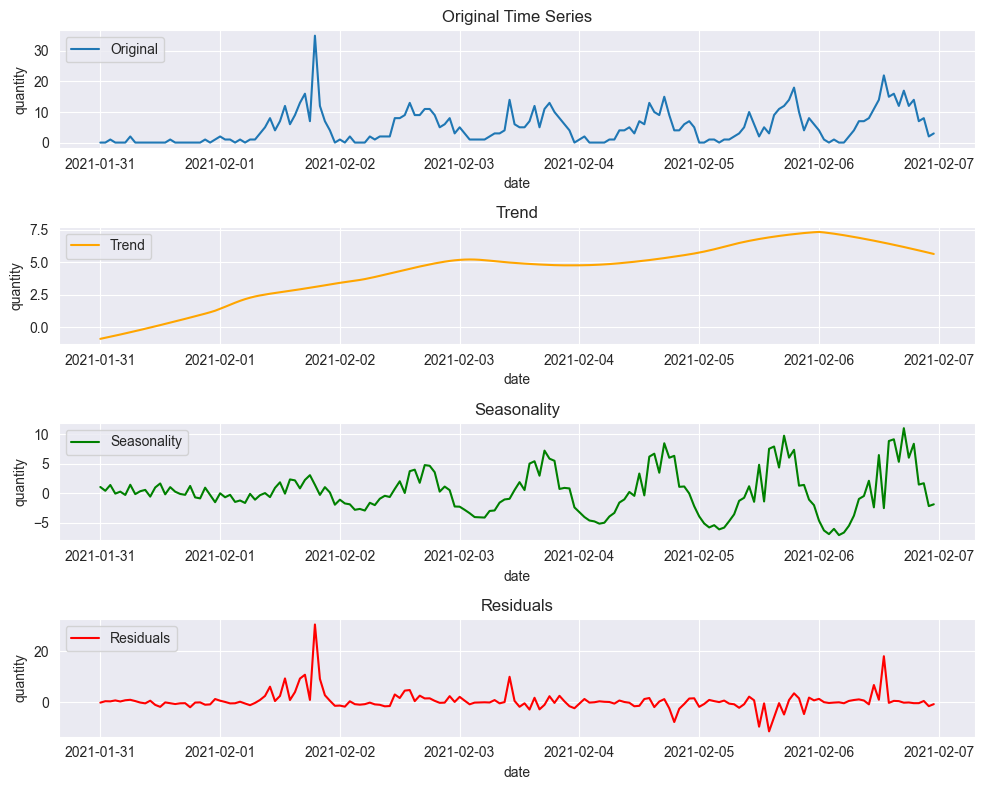

In [43]:
plot_decomposition(df_most_popular_coca_cola_all)

Проверим на стационарность обобщенный по всем регионам ряд

In [44]:
from statsmodels.tsa.stattools import adfuller


def test_stationarity_adf(timeseries):
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    return dfoutput.reset_index().rename(columns={'index': 'Statistic', 0: 'Value'})

test_stationarity_adf(df_most_popular_coca_cola_all.groupby('date')['quantity'].sum())

,Statistic,Value
0,Test Statistic,-4.300096
1,p-value,0.000444
2,Lags Used,4.000000
3,Number of Observations Used,163.000000
4,Critical Value (1%),-3.471119
5,Critical Value (5%),-2.879441
6,Critical Value (10%),-2.576314


$p-value < 0.05$, что говорит о стационарности ряда

# Моделирование

## RandomForest

В качестве первой модели возьмем RandomForest. В начале подберем гиперпараметры

In [45]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

LOAD_FROM_FILE_MODEL_PARAMS_RF = True
if LOAD_FROM_FILE_MODEL_PARAMS_RF:
    rf_random = joblib.load('models_params/rf_random_s.joblib')
else:
    param_rand_rf = {
        'random_state': [42],
        'n_jobs': [-1],
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [None, 10, 20, 30, 50],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'max_features': ['sqrt', 'log2', None],
    }

    model_rf_rand = RandomForestClassifier()
    rf_random = RandomizedSearchCV(estimator=model_rf_rand,
                                   param_distributions=param_rand_rf,
                                   scoring='neg_mean_absolute_error',
                                   n_iter=50,
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

    rf_random.fit(X, y)
    joblib.dump(rf_random, 'models_params/rf_random_s.joblib')

rf_random.best_params_

{'random_state': 42,
 'n_jobs': -1,
 'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 4,
 'max_features': 'log2',
 'max_depth': 10}

Обучим модель с подобранными гиперпараметрами и выведем метрики качества

In [46]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

model_rf = RandomForestRegressor(**rf_random.best_params_)
model_rf.fit(X, y)

y_pred_rf = model_rf.predict(X).astype(y.dtype)
mae_rf = mean_absolute_error(y, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y, y_pred_rf))
print(f"Mean Absolute Error: {mae_rf:.2f}")
print(f"Root Mean Squared Error: {rmse_rf:.2f}")

Mean Absolute Error: 0.10
Root Mean Squared Error: 0.50


Получили довольно неплохие показатели

Построим график фактических и предсказанных значений

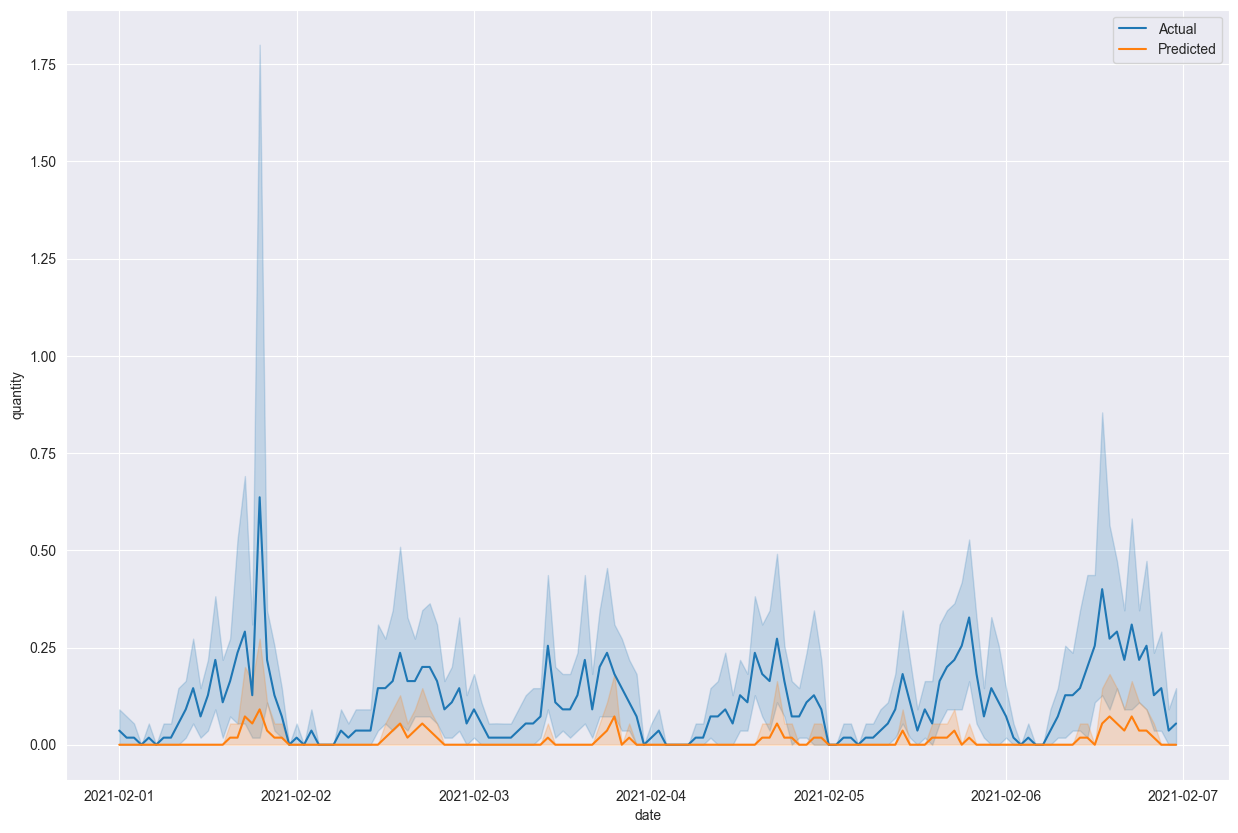

In [47]:
df_test = pd.DataFrame({'date': df_for_regressor['date'], 'quantity': y, 'quantity_pred': y_pred_rf})

plt.figure(figsize=(15, 10))
sns.lineplot(data=df_test, x='date', y='quantity', label='Actual')
sns.lineplot(data=df_test, x='date', y='quantity_pred', label='Predicted')
plt.legend()
plt.show()

Сделаем прогноз на следующие сутки от последней даты для каждого региона

In [48]:
def forecast_next_day(last_data, model, num_hours=24):
    forecasts = []
    input_data = last_data.copy()
    for i in range(num_hours):
        pred = model.predict(input_data[features].iloc[-1:].values)[0]
        pred = int(max(0, pred))
        forecasts.append(pred)
        input_data = pd.concat([input_data, pd.DataFrame({**{col: [0] for col in features}, 'quantity': [pred]})])
        input_data = create_lags(input_data, ['quantity'], lags=24).fillna(0)
    return forecasts


forecasts_rf = {}
for region in df_for_regressor['region'].unique():
    last_data = df_for_regressor[df_for_regressor['region'] == region].copy()
    forecast = forecast_next_day(last_data, model_rf)
    forecasts_rf[region] = forecast

forecasts_rf = pd.DataFrame(forecasts_rf)
forecasts_rf

,Алтайский край,Архангельская область,Астраханская область,Белгородская область,Брянская область,Владимирская область,Волгоградская область,Воронежская область,Иркутская область,Кабардино-Балкарская Республика,...,Саратовская область,Свердловская область,Ставропольский край,Тверская область,Томская область,Тюменская область,Ульяновская область,Ханты-Мансийский автономный округ,Челябинская область,Ямало-Ненецкий автономный округ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Получили нулевой прогноз на следующие сутки для каждого региона. Это может быть связано с тем, что у нас мало действительных измерений и много пропусков, которые мы заполнили 0

## XGBoost

Попробуем обучить модель XGBoost. Подберем гиперпараметры

In [49]:
from sklearn.model_selection import RandomizedSearchCV
from xgboost import XGBRegressor

LOAD_FROM_FILE_MODEL_PARAMS_XGB = True
if LOAD_FROM_FILE_MODEL_PARAMS_XGB:
    xgb_random = joblib.load('models_params/xgb_random_s.joblib')
else:
    param_rand_xgb = {
        'random_state': [42],
        'n_jobs': [-1],
        'n_estimators': [100, 200, 500, 1000],
        'max_depth': [3, 5, 7, 10],
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'gamma': [0, 0.1, 0.3, 0.5],
    }

    model_xgb_rand = XGBRegressor()
    xgb_random = RandomizedSearchCV(estimator=model_xgb_rand,
                                   param_distributions=param_rand_xgb,
                                   scoring='neg_mean_absolute_error',
                                   n_iter=50,
                                   cv=3,
                                   verbose=2,
                                   random_state=42,
                                   n_jobs=-1)

    xgb_random.fit(X, y)
    joblib.dump(xgb_random, 'models_params/xgb_random_s.joblib')

xgb_random.best_params_

{'subsample': 0.6,
 'random_state': 42,
 'n_jobs': -1,
 'n_estimators': 1000,
 'max_depth': 3,
 'learning_rate': 0.1,
 'gamma': 0,
 'colsample_bytree': 1.0}

Обучим модель с подобранными гиперпараметрами и выведем метрики качества

In [50]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

model_xgb = XGBRegressor(**xgb_random.best_params_)
model_xgb.fit(X, y)

y_pred_xgb = model_xgb.predict(X).astype(y.dtype)
mae_xgb = mean_absolute_error(y, y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(y, y_pred_xgb))
print(f"Mean Absolute Error: {mae_xgb:.2f}")
print(f"Root Mean Squared Error: {rmse_xgb:.2f}")

Mean Absolute Error: 0.08
Root Mean Squared Error: 0.31


Получили показатели еще лучше

Построим график фактических и предсказанных значений


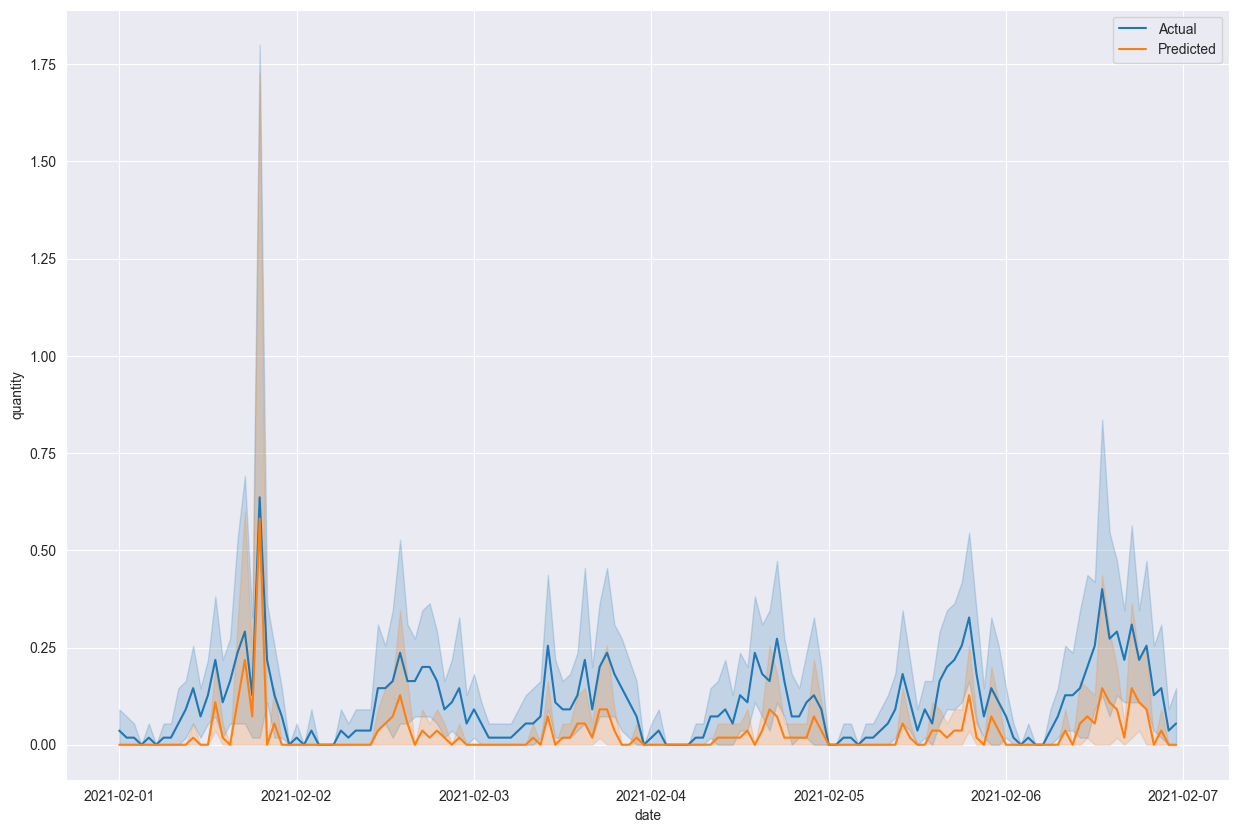

In [51]:
df_test = pd.DataFrame({'date': df_for_regressor['date'], 'quantity': y, 'quantity_pred': y_pred_xgb})

plt.figure(figsize=(15, 10))
sns.lineplot(data=df_test, x='date', y='quantity', label='Actual')
sns.lineplot(data=df_test, x='date', y='quantity_pred', label='Predicted')
plt.legend()
plt.show()

Сделаем прогноз на следующие сутки от последней даты для каждого региона


In [52]:
def forecast_next_day(last_data, model, num_hours=24):
    forecasts = []
    input_data = last_data.copy()
    for i in range(num_hours):
        pred = model.predict(input_data[features].iloc[-1:].values)[0]
        pred = int(max(0, pred))
        forecasts.append(pred)
        input_data = pd.concat([input_data, pd.DataFrame({**{col: [0] for col in features}, 'quantity': [pred]})])
        input_data = create_lags(input_data, ['quantity'], lags=24).fillna(0)
    return forecasts


forecasts_xgboost = {}
for region in df_for_regressor['region'].unique():
    last_data = df_for_regressor[df_for_regressor['region'] == region].copy()
    forecast = forecast_next_day(last_data, model_xgb)
    forecasts_xgboost[region] = forecast

forecasts_xgboost = pd.DataFrame(forecasts_xgboost)
forecasts_xgboost

,Алтайский край,Архангельская область,Астраханская область,Белгородская область,Брянская область,Владимирская область,Волгоградская область,Воронежская область,Иркутская область,Кабардино-Балкарская Республика,...,Саратовская область,Свердловская область,Ставропольский край,Тверская область,Томская область,Тюменская область,Ульяновская область,Ханты-Мансийский автономный округ,Челябинская область,Ямало-Ненецкий автономный округ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Вновь получили нулевые прогнозы. Попробуем применить другие техники

## AR
Попробуем применить модель авторегрессии

In [53]:
from statsmodels.tsa.ar_model import AutoReg

lags = 24
model_ar = AutoReg(df_for_regressor_date_set_index, lags=lags).fit()

mae_ar = mean_absolute_error(df_for_regressor_date_set_index[lags:], model_ar.fittedvalues)
rmse_ar = np.sqrt(mean_squared_error(df_for_regressor_date_set_index[lags:], model_ar.fittedvalues))
print(f"Mean Absolute Error: {mae_ar:.2f}")
print(f"Root Mean Squared Error: {rmse_ar:.2f}")

Mean Absolute Error: 1.96
Root Mean Squared Error: 2.64


/Users/grigoriy/Developer/JetBrains_projects/PycharmProjects/ml_course/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


Спрогнозируем продажи на следующие сутки обобщенно по всем регионам

In [54]:
forecast_values = model_ar.predict(start=len(df_for_regressor_date_set_index), end=len(df_for_regressor_date_set_index) + 23)
forecast_ar = pd.Series(forecast_values, index=pd.date_range(df_for_regressor_date_set_index.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H'))
forecast_ar = forecast_ar.apply(lambda x: int(max(0, x)))
forecast_ar.rename('quantity', inplace=True)
forecast_ar

2021-02-07 00:00:00     0
2021-02-07 01:00:00     0
2021-02-07 02:00:00     0
2021-02-07 03:00:00     0
2021-02-07 04:00:00     0
2021-02-07 05:00:00     0
2021-02-07 06:00:00     2
2021-02-07 07:00:00     3
2021-02-07 08:00:00     5
2021-02-07 09:00:00     7
2021-02-07 10:00:00     9
2021-02-07 11:00:00    11
2021-02-07 12:00:00    12
2021-02-07 13:00:00    13
2021-02-07 14:00:00    13
2021-02-07 15:00:00    13
2021-02-07 16:00:00    12
2021-02-07 17:00:00    11
2021-02-07 18:00:00     9
2021-02-07 19:00:00     8
2021-02-07 20:00:00     6
2021-02-07 21:00:00     4
2021-02-07 22:00:00     2
2021-02-07 23:00:00     1
Freq: H, Name: quantity, dtype: int64

Спрогнозируем для каждого региона отдельно

In [55]:
LOAD_FROM_FILE_MODEL_FORECASTS_AR = True
if LOAD_FROM_FILE_MODEL_FORECASTS_AR:
    forecasts_ar = pd.read_csv('forecasts/forecasts_ar_s.csv')
else:
    forecasts_ar = {}
    for region in df_for_regressor['region'].unique():
        data = df_for_regressor[df_for_regressor['region'] == region].groupby('date')['quantity'].sum()
        model = AutoReg(data, lags=lags).fit()
        forecast_values = model.predict(start=len(data), end=len(data) + 23)
        forecast = pd.Series(forecast_values, index=pd.date_range(data.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H'))
        forecast = forecast.apply(lambda x: int(max(0, x)))
        forecasts_ar[region] = forecast

    forecasts_ar = pd.DataFrame(forecasts_ar)
    forecasts_ar.to_csv('forecasts/forecasts_ar_s.csv', index=False)

forecasts_ar

,Алтайский край,Архангельская область,Астраханская область,Белгородская область,Брянская область,Владимирская область,Волгоградская область,Воронежская область,Иркутская область,Кабардино-Балкарская Республика,...,Саратовская область,Свердловская область,Ставропольский край,Тверская область,Томская область,Тюменская область,Ульяновская область,Ханты-Мансийский автономный округ,Челябинская область,Ямало-Ненецкий автономный округ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,2,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,3,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Получили ненулевые прогнозы только в Волгоградской, Иркутской, Московской областях и Краснодарском и Красноярском краях

## MA
Попробуем применить модель скользящего среднего

In [56]:
def moving_average(data, window):
    return data.rolling(window=window).mean().shift(1)


window = 24
model_ma = df_for_regressor_date_set_index.rolling(window=window).mean().shift(1)

mae_ma = mean_absolute_error(df_for_regressor_date_set_index[window:], model_ma[window:])
rmse_ma = np.sqrt(mean_squared_error(df_for_regressor_date_set_index[window:], model_ma[window:]))
print(f"Mean Absolute Error: {mae_ma:.2f}")
print(f"Mean Squared Error: {rmse_ma:.2f}")

Mean Absolute Error: 3.88
Mean Squared Error: 4.72


Спрогнозируем продажи на следующие сутки обобщенно по всем регионам

In [57]:
forecast_ma = moving_average(df_for_regressor_date_set_index, window).iloc[-24:]
forecast_ma.index = pd.date_range(df_for_regressor_date_set_index.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')
forecast_ma = forecast_ma.apply(lambda x: int(max(0, x)))
forecast_ma.rename('quantity', inplace=True)
forecast_ma

2021-02-07 00:00:00    5
2021-02-07 01:00:00    5
2021-02-07 02:00:00    5
2021-02-07 03:00:00    5
2021-02-07 04:00:00    5
2021-02-07 05:00:00    5
2021-02-07 06:00:00    5
2021-02-07 07:00:00    5
2021-02-07 08:00:00    5
2021-02-07 09:00:00    5
2021-02-07 10:00:00    6
2021-02-07 11:00:00    5
2021-02-07 12:00:00    6
2021-02-07 13:00:00    6
2021-02-07 14:00:00    7
2021-02-07 15:00:00    7
2021-02-07 16:00:00    8
2021-02-07 17:00:00    8
2021-02-07 18:00:00    8
2021-02-07 19:00:00    8
2021-02-07 20:00:00    8
2021-02-07 21:00:00    8
2021-02-07 22:00:00    8
2021-02-07 23:00:00    7
Freq: H, Name: quantity, dtype: int64

Спрогнозируем для каждого региона отдельно

In [58]:
LOAD_FROM_FILE_MODEL_FORECASTS_MA = True
if LOAD_FROM_FILE_MODEL_FORECASTS_MA:
    forecasts_ma = pd.read_csv('forecasts/forecasts_ma_s.csv')
else:
    forecasts_ma = {}
    for region in df_for_regressor['region'].unique():
        data = df_for_regressor[df_for_regressor['region'] == region].groupby('date')['quantity'].sum()
        forecast = moving_average(data, window).iloc[-24:]
        forecast.index = pd.date_range(data.index[-1] + pd.Timedelta(hours=1), periods=24, freq='H')
        forecast = forecast.apply(lambda x: int(max(0, x)))
        forecasts_ma[region] = forecast

    forecasts_ma = pd.DataFrame(forecasts_ma)
    forecasts_ma.to_csv('forecasts/forecasts_ma_s.csv', index=False)

forecasts_ma

,Алтайский край,Архангельская область,Астраханская область,Белгородская область,Брянская область,Владимирская область,Волгоградская область,Воронежская область,Иркутская область,Кабардино-Балкарская Республика,...,Саратовская область,Свердловская область,Ставропольский край,Тверская область,Томская область,Тюменская область,Ульяновская область,Ханты-Мансийский автономный округ,Челябинская область,Ямало-Ненецкий автономный округ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Получили ненулевые прогнозы только в Московской области

## ARIMA

Попробуем применить модель ARIMA. Это модель представляет собой комбинацию авторегрессии (AR) и скользящего среднего (MA) для нестационарных рядов

In [59]:
from statsmodels.tsa.arima.model import ARIMA
from itertools import product


def arima_model(data, order):
    model = ARIMA(data, order=order, freq='H')
    model_fit = model.fit()
    return model_fit


def grid_search_arima(data, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q in product(p_values, d_values, q_values):
        order = (p, d, q)
        try:
            model_fit = arima_model(data, order)
            score = model_fit.aic
            if score < best_score:
                best_score, best_cfg = score, order
        except:
            continue
    return best_cfg


p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)

LOAD_FROM_FILE_MODEL_PARAMS_ARIMA = True
if LOAD_FROM_FILE_MODEL_PARAMS_ARIMA:
    best_cfg_arima = joblib.load('models_params/best_cfg_arima_s.joblib')
else:
    best_cfg_arima = grid_search_arima(df_for_regressor_date_set_index, p_values, d_values, q_values)
    joblib.dump(best_cfg_arima, 'models_params/best_cfg_arima_s.joblib')

best_cfg_arima

(1, 0, 1)

In [60]:
model_arima = arima_model(df_for_regressor_date_set_index, order=best_cfg_arima)

mae_arima = mean_absolute_error(df_for_regressor_date_set_index, model_arima.fittedvalues)
rmse_arima = np.sqrt(mean_squared_error(df_for_regressor_date_set_index, model_arima.fittedvalues))
print(f"Mean Absolute Error: {mae_arima:.2f}")
print(f"Root Mean Squared Error: {rmse_arima:.2f}")

Mean Absolute Error: 2.70
Root Mean Squared Error: 3.97


/Users/grigoriy/Developer/JetBrains_projects/PycharmProjects/ml_course/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


Спрогнозируем продажи на следующие сутки обобщенно по всем регионам

In [61]:
forecast_arima = model_arima.forecast(steps=24)
forecast_arima = forecast_arima.apply(lambda x: int(max(0, x)))
forecast_arima.rename('quantity', inplace=True)
forecast_arima

2021-02-07 00:00:00    3
2021-02-07 01:00:00    4
2021-02-07 02:00:00    4
2021-02-07 03:00:00    4
2021-02-07 04:00:00    4
2021-02-07 05:00:00    5
2021-02-07 06:00:00    5
2021-02-07 07:00:00    5
2021-02-07 08:00:00    5
2021-02-07 09:00:00    5
2021-02-07 10:00:00    5
2021-02-07 11:00:00    5
2021-02-07 12:00:00    5
2021-02-07 13:00:00    5
2021-02-07 14:00:00    5
2021-02-07 15:00:00    5
2021-02-07 16:00:00    5
2021-02-07 17:00:00    5
2021-02-07 18:00:00    5
2021-02-07 19:00:00    5
2021-02-07 20:00:00    5
2021-02-07 21:00:00    5
2021-02-07 22:00:00    5
2021-02-07 23:00:00    5
Freq: H, Name: quantity, dtype: int64

Спрогнозируем для каждого региона отдельно

In [62]:
LOAD_FROM_FILE_MODEL_FORECASTS_ARIMA = True
if LOAD_FROM_FILE_MODEL_FORECASTS_ARIMA:
    forecasts_arima = pd.read_csv('forecasts/forecasts_arima_s.csv')
else:
    forecasts_arima = {}
    for region in df_for_regressor['region'].unique():
        data = df_for_regressor[df_for_regressor['region'] == region].groupby('date')['quantity'].sum()
        best_cfg_each_reg = grid_search_arima(data, p_values, d_values, q_values)
        model = arima_model(data, order=best_cfg_each_reg)
        forecast = model.forecast(steps=24)
        forecast = forecast.apply(lambda x: int(max(0, x)))
        forecasts_arima[region] = forecast

    forecasts_arima = pd.DataFrame(forecasts_arima)
    forecasts_arima.to_csv('forecasts/forecasts_arima_s.csv', index=False)

forecasts_arima

,Алтайский край,Архангельская область,Астраханская область,Белгородская область,Брянская область,Владимирская область,Волгоградская область,Воронежская область,Иркутская область,Кабардино-Балкарская Республика,...,Саратовская область,Свердловская область,Ставропольский край,Тверская область,Томская область,Тюменская область,Ульяновская область,Ханты-Мансийский автономный округ,Челябинская область,Ямало-Ненецкий автономный округ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Получили все нулевые прогнозы

## SARIMAX

Теперь попробуем применить модель SARIMAX. Это модель представляет собой комбинацию авторегрессии (AR), скользящего среднего (MA) и модели сезонности (S) для нестационарных рядов

In [63]:
import itertools
import statsmodels.api as sm


def sarimax_model(data, order, seasonal_order):
    model = sm.tsa.statespace.SARIMAX(data, order=order, seasonal_order=seasonal_order, freq='H')
    model_fit = model.fit(disp=False)
    return model_fit


def grid_search_sarimax(data, p_values, d_values, q_values, P_values, D_values, Q_values, m_values):
    best_score, best_cfg = float("inf"), None
    for p, d, q, P, D, Q, m in itertools.product(p_values, d_values, q_values, P_values, D_values, Q_values, m_values):
        order = (p, d, q)
        seasonal_order = (P, D, Q, m)
        try:
            model_fit = sarimax_model(data, order, seasonal_order)
            score = model_fit.aic
            if score < best_score:
                best_score, best_cfg = score, (order, seasonal_order)
        except:
            continue
    return best_cfg


p_values = range(0, 2)
d_values = range(0, 2)
q_values = range(0, 2)
P_values = range(0, 2)
D_values = range(0, 2)
Q_values = range(0, 2)
m_values = [24]


LOAD_FROM_FILE_MODEL_PARAMS_SARIMAX = True
if LOAD_FROM_FILE_MODEL_PARAMS_SARIMAX:
    best_cfg = joblib.load('models_params/best_cfg_s.joblib')
else:
    best_cfg = grid_search_sarimax(df_for_regressor_date_set_index, p_values, d_values, q_values, P_values, D_values,
                                   Q_values, m_values)
    joblib.dump(best_cfg, 'models_params/best_cfg_s.joblib')
best_cfg


((1, 0, 0), (0, 1, 1, 24))

In [64]:
model_sarimax = sarimax_model(df_for_regressor_date_set_index, order=best_cfg[0], seasonal_order=best_cfg[1])

mae_sarimax = mean_absolute_error(df_for_regressor_date_set_index, model_sarimax.fittedvalues)
rmse_sarimax = np.sqrt(mean_squared_error(df_for_regressor_date_set_index, model_sarimax.fittedvalues))
print(f"Mean Absolute Error: {mae_sarimax:.2f}")
print(f"Root Mean Squared Error: {rmse_sarimax:.2f}")

/Users/grigoriy/Developer/JetBrains_projects/PycharmProjects/ml_course/venv/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


Mean Absolute Error: 3.17
Root Mean Squared Error: 5.56


Спрогнозируем продажи на следующие сутки обобщенно по всем регионам

In [65]:
forecast_sarimax = model_sarimax.forecast(steps=24)
forecast_sarimax = forecast_sarimax.apply(lambda x: int(max(0, x)))
forecast_sarimax.rename('quantity', inplace=True)
forecast_sarimax

2021-02-07 00:00:00     2
2021-02-07 01:00:00     1
2021-02-07 02:00:00     0
2021-02-07 03:00:00     0
2021-02-07 04:00:00     0
2021-02-07 05:00:00     0
2021-02-07 06:00:00     1
2021-02-07 07:00:00     2
2021-02-07 08:00:00     3
2021-02-07 09:00:00     4
2021-02-07 10:00:00     7
2021-02-07 11:00:00     6
2021-02-07 12:00:00     7
2021-02-07 13:00:00     9
2021-02-07 14:00:00     9
2021-02-07 15:00:00    10
2021-02-07 16:00:00     9
2021-02-07 17:00:00    13
2021-02-07 18:00:00    10
2021-02-07 19:00:00    14
2021-02-07 20:00:00     7
2021-02-07 21:00:00     6
2021-02-07 22:00:00     5
2021-02-07 23:00:00     2
Freq: H, Name: quantity, dtype: int64

Спрогнозируем для каждого региона отдельно

In [66]:
LOAD_FROM_FILE_MODEL_FORECASTS_SARIMAX = True
if LOAD_FROM_FILE_MODEL_FORECASTS_SARIMAX:
    forecasts_sarimax = pd.read_csv('forecasts/forecasts_sarimax_s.csv')
else:
    forecasts_sarimax = {}
    for region in df_for_regressor['region'].unique():
        data = df_for_regressor[df_for_regressor['region'] == region].groupby('date')['quantity'].sum()
        best_cfg_each_reg = grid_search_sarimax(data, p_values, d_values, q_values, P_values, D_values,
                                                Q_values, m_values)
        model = sarimax_model(data, order=best_cfg_each_reg[0], seasonal_order=best_cfg_each_reg[1])
        forecast = model.forecast(steps=24)
        forecast = forecast.apply(lambda x: int(max(0, x)))
        forecasts_sarimax[region] = forecast

    forecasts_sarimax = pd.DataFrame(forecasts_sarimax)
    forecasts_sarimax.to_csv('forecasts/forecasts_sarimax_s.csv', index=False)

forecasts_sarimax

,Алтайский край,Архангельская область,Астраханская область,Белгородская область,Брянская область,Владимирская область,Волгоградская область,Воронежская область,Иркутская область,Кабардино-Балкарская Республика,...,Саратовская область,Свердловская область,Ставропольский край,Тверская область,Томская область,Тюменская область,Ульяновская область,Ханты-Мансийский автономный округ,Челябинская область,Ямало-Ненецкий автономный округ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Получили ненулевые прогнозы только в Краснодарском, Пермском краях, Московской, Омской, Самарской областях, Республиках Саха (Якутия) и Хакасия, Москве и Санкт-Петербурге

## Prophet
Попробуем применить модель Prophet

In [67]:
from prophet import Prophet

df_prophet = df_for_regressor_date_set_index.reset_index()
df_prophet.columns = ['ds', 'y']

model_prophet = Prophet()
model_prophet.fit(df_prophet)

future = model_prophet.make_future_dataframe(periods=24, freq='H')
forecast_prophet = model_prophet.predict(future)
forecast_prophet = forecast_prophet.set_index('ds')['yhat'].apply(lambda x: int(max(0, x)))

mae_prophet = mean_absolute_error(df_prophet['y'], forecast_prophet[:-24])
rmse_prophet = np.sqrt(mean_squared_error(df_prophet['y'], forecast_prophet[:-24]))
print(f"Mean Absolute Error: {mae_prophet:.2f}")
print(f"Root Mean Squared Error: {rmse_prophet:.2f}")

Importing plotly failed. Interactive plots will not work.
09:02:27 - cmdstanpy - INFO - Chain [1] start processing
09:02:27 - cmdstanpy - INFO - Chain [1] done processing


Mean Absolute Error: 1.94
Root Mean Squared Error: 3.33


Cпрогнозируем продажи на следующие сутки обобщенно по всем регионам

In [68]:
forecast_prophet = forecast_prophet.iloc[-24:]
forecast_prophet

ds
2021-02-07 00:00:00     3
2021-02-07 01:00:00     2
2021-02-07 02:00:00     2
2021-02-07 03:00:00     1
2021-02-07 04:00:00     1
2021-02-07 05:00:00     1
2021-02-07 06:00:00     2
2021-02-07 07:00:00     3
2021-02-07 08:00:00     5
2021-02-07 09:00:00     6
2021-02-07 10:00:00     7
2021-02-07 11:00:00     8
2021-02-07 12:00:00     9
2021-02-07 13:00:00    10
2021-02-07 14:00:00    10
2021-02-07 15:00:00    11
2021-02-07 16:00:00    12
2021-02-07 17:00:00    13
2021-02-07 18:00:00    14
2021-02-07 19:00:00    13
2021-02-07 20:00:00    11
2021-02-07 21:00:00     8
2021-02-07 22:00:00     6
2021-02-07 23:00:00     4
Name: yhat, dtype: int64

Спрогнозируем для каждого региона отдельно

In [69]:
LOAD_FROM_FILE_MODEL_FORECASTS_PROPHET = True
if LOAD_FROM_FILE_MODEL_FORECASTS_PROPHET:
    forecasts_prophet = pd.read_csv('forecasts/forecasts_prophet_s.csv')
else:
    forecasts_prophet = {}
    for region in df_for_regressor['region'].unique():
        data = df_for_regressor[df_for_regressor['region'] == region].groupby('date')['quantity'].sum().reset_index()
        data.columns = ['ds', 'y']
        model = Prophet()
        model.fit(data)
        future = model.make_future_dataframe(periods=24, freq='H')
        forecast = model.predict(future)
        forecast = forecast.set_index('ds')['yhat'].apply(lambda x: int(max(0, x)))
        forecasts_prophet[region] = forecast[-24:]

    forecasts_prophet = pd.DataFrame(forecasts_prophet)
    forecasts_prophet.to_csv('forecasts/forecasts_prophet_s.csv', index=False)

forecasts_prophet

,Алтайский край,Архангельская область,Астраханская область,Белгородская область,Брянская область,Владимирская область,Волгоградская область,Воронежская область,Иркутская область,Кабардино-Балкарская Республика,...,Саратовская область,Свердловская область,Ставропольский край,Тверская область,Томская область,Тюменская область,Ульяновская область,Ханты-Мансийский автономный округ,Челябинская область,Ямало-Ненецкий автономный округ
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Получили ненулевые прогнозы только в Краснодарском крае, Московской области и Санкт-Петербурге

## Сравнение моделей для временного ряда

In [70]:
predictions = [forecast_ar.rename('AR'), forecast_ma.rename('MA'), forecast_arima.rename('ARIMA'), forecast_sarimax.rename('SARIMAX'), forecast_prophet.rename('Prophet')]
df_predictions = pd.concat(predictions, axis=1)
df_predictions

,AR,MA,ARIMA,SARIMAX,Prophet
2021-02-07 00:00:00,0,5,3,2,3
2021-02-07 01:00:00,0,5,4,1,2
2021-02-07 02:00:00,0,5,4,0,2
2021-02-07 03:00:00,0,5,4,0,1
2021-02-07 04:00:00,0,5,4,0,1
2021-02-07 05:00:00,0,5,5,0,1
2021-02-07 06:00:00,2,5,5,1,2
2021-02-07 07:00:00,3,5,5,2,3
2021-02-07 08:00:00,5,5,5,3,5
2021-02-07 09:00:00,7,5,5,4,6


Изобразим прогнозы на графике

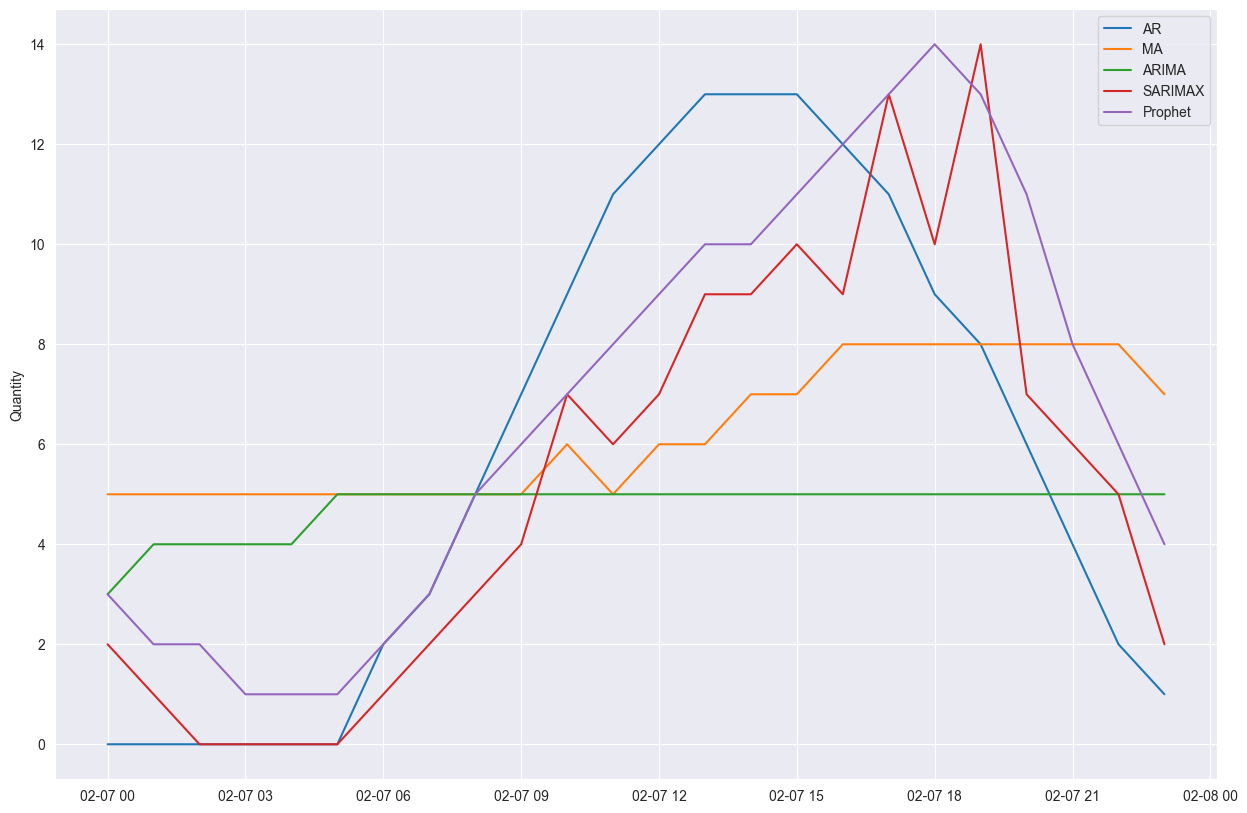

In [71]:
plt.figure(figsize=(15, 10))
for column in df_predictions.columns:
    sns.lineplot(data=df_predictions[column], label=column)
plt.ylabel('Quantity')
plt.legend()
plt.show()

Сравним метрики моделей

In [72]:
models = ['AR', 'MA', 'ARIMA', 'SARIMAX', 'Prophet']
mae = [mae_ar, mae_ma, mae_arima, mae_sarimax, mae_prophet]
rmse = [rmse_ar, rmse_ma, rmse_arima, rmse_sarimax, rmse_prophet]

df_metrics = pd.DataFrame({'Model': models, 'MAE': mae, 'RMSE': rmse})
df_metrics.sort_values(by='MAE')

,Model,MAE,RMSE
4,Prophet,1.937500,3.334375
0,AR,1.961115,2.638503
2,ARIMA,2.700498,3.967189
3,SARIMAX,3.165773,5.559836
1,MA,3.880556,4.720382


Лучшей моделью по метрике MAE оказалась модель Prophet, по RMSE - модель AR

# Вывод

Нам было необходимо разработать модель, которая бы предсказывала объем продаж товара Coca Cola на следующие сутки для каждого региона.

Мы провели анализ данных и выделили признаки. В нашем датасете было много недостающих данных объема продаж по датам и часам.
Мы сделали предположение, что продаж не было в те дни и часы, где данных не было, и заполнили их нулями.

Далее мы использовали модели RandomForest, XGBoost, AR, MA, ARIMA, SARIMAX и Prophet для прогнозирования объема продаж на следующие сутки.

Модели RandomForest и XGBoost показали хорошие метрики, но их прогнозы на следующие сутки для каждого региона оказались нулевыми.

На обобщенных по дате данных по всем регионам лучшей моделью по MAE оказалась Prophet, по RMSE - AR.
Прогнозы на следующие сутки для каждого региона у моделей AR, MA, ARIMA, SARIMAX и Prophet практически все оказались нулевыми.

В нашем случае лучше всего для прогноза использовать модель AR или Prophet, обученную на обобщенных по дате данных по всем регионам.


Проблемы с нулевыми прогнозами в большей степени связаны с отсутствием достаточного количества данных, поэтому для улучшения качества прогноза можно попробовать:
- Собрать больше данных
- Попробовать другие методы заполнения пропусков
- Попробовать другие методы генерации признаков
